In [1]:
# ! pip install lime
# ! pip install shap
# ! pip install sklearn
# ! pip install xgboost
# ! pip instsall matplotlib seaborn pandas numpy

# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html#Explain-predictions

# XAI Assignment 1

Jisoo Jang (2022-35854)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  # matplotlib version should be == 3.4.3
import pandas as pd
import lime
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report
from pathlib import Path

import xgboost as xgb
import shap


pd.set_option('display.max_columns', None)
shap.initjs()

def separate_dataset(X, y):
    length = len(X)
    train_length = int(0.8 * length)
    X_train, y_train = X.iloc[:train_length, :], y[:train_length]
    X_test, y_test = X.iloc[train_length:], y[train_length:]
    return X_train, y_train, X_test, y_test

## Notice

I solved the tasks with following settings:

- Classification Task = Predicting On-Time with E-commerce dataset
- Regression Task = Predicing housing prices with Beijing Housing Prices

# Explaining Predictions of Classification Models

## Ecommerce Dataset

An international e-commerce company based wants to discover key insights from their customer database. They want to use some of the most advanced machine learning techniques to study their customers. The company sells electronic products.

Content
The dataset used for model building contained **10999** observations of 12 variables.
The data contains the following information:

- ID: ID Number of Customers.
- Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
- Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
- Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
- Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
- Cost of the product: Cost of the Product in US Dollars.
- Prior purchases: The Number of Prior Purchase.
- Product importance: The company has categorized the product in the various parameter such as low, medium, high.
- Gender: Male and Female.
- Discount offered: Discount offered on that specific product.
- Weight in gms: It is the weight in grams.
- Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

In [2]:
ecommerce = pd.read_csv("../data/ecommerce/ecommerce.csv")
ecommerce.tail(5)

ID Warehouse_block Mode_of_Shipment  Customer_care_calls  \
10994  10995               A             Ship                    4   
10995  10996               B             Ship                    4   
10996  10997               C             Ship                    5   
10997  10998               F             Ship                    5   
10998  10999               D             Ship                    2   

       Customer_rating  Cost_of_the_Product  Prior_purchases  \
10994                1                  252                5   
10995                1                  232                5   
10996                4                  242                5   
10997                2                  223                6   
10998                5                  155                5   

      Product_importance Gender  Discount_offered  Weight_in_gms  \
10994             medium      F                 1           1538   
10995             medium      F                 6           1247   
10996                low      F                 4           1155   
10997             medium      M                 2           1210   
10998                low      F                 6           1639   

       Reached.on.Time_Y.N  
10994                    1  
10995                    0  
10996                    0  
10997                    0  
10998                    0

## Model Building

In [3]:
from pathlib import Path
from collections import defaultdict

def get_ecommerce(data_path, onehot_cols=None, target_feature=None):
    encode_dict = defaultdict()
    ecommerce = pd.read_csv(data_path / 'ecommerce' / 'ecommerce.csv')
    ecommerce.drop(columns=['ID'], inplace=True)
    cols = ['Warehouse_block', 'Mode_of_Shipment', 'Customer_rating', 'Gender', 'Product_importance']
    encode_dict['Product_importance'] = {'low': 0, 'medium': 1, 'high': 2}
    encode_dict['Gender'] = {'M': 0, 'F': 1}
    encode_dict['Mode_of_Shipment'] = {'Flight': 0, 'Ship': 1, 'Road': 2}
    encode_dict['Warehouse_block'] = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'F': 4}
    encode_dict['Customer_rating'] = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
    assert target_feature is not None, 'missing target'
    for c in cols:
        if (onehot_cols is not None) and (c in onehot_cols):
            if target_feature == c:
                ecommerce[c].replace(to_replace=encode_dict[c], inplace=True)
            else:
                df_onehot = pd.get_dummies(ecommerce[c])
                new_cols = f'{c}_' + df_onehot.columns.astype(str)
                df_onehot.rename(columns=dict(zip(df_onehot.columns, new_cols)), inplace=True)
                ecommerce.drop(columns=[c], inplace=True)
                ecommerce = pd.concat([ecommerce, df_onehot], axis=1)
        else:
            ecommerce[c].replace(to_replace=encode_dict[c], inplace=True)
    return ecommerce, encode_dict

def load_rating_data(data_path, onehot_cols=None, target_feature=None):
    rating_data, encode_dict = get_ecommerce(data_path, onehot_cols, target_feature)
    rating_data = rating_data.sample(frac=1)
    rating_data_y = rating_data.loc[:, target_feature]
    cols = [c for c in rating_data.columns if c != target_feature]
    rating_data_X = rating_data.loc[:, cols]

    return rating_data_X, rating_data_y, encode_dict

In [4]:
checkpoints = Path() / 'checkpoints'
if not checkpoints.exists():
    checkpoints.mkdir()

config = {
    'params': {
        'n_estimators': 1000,
        'max_depth' : 4,
        'learning_rate': 0.001, 
        'min_child_weight': 2,
        'objective' : 'binary:logistic',
        'eval_metric' : ['logloss', 'error'],
        'tree_method': 'hist',
        'random_state': 7,
        'use_label_encoder': False,
        'n_jobs': 10,
        'reg_lambda': 1e-4
    },
    'data': {
        # 'onehot_cols': [ 'Warehouse_block', 'Mode_of_Shipment', 'Customer_rating', 'Gender', 'Product_importance'],
        # 'onehot_cols': [ 'Warehouse_block', 'Mode_of_Shipment'],
        'onehot_cols': None,
        'target_feature': 'Reached.on.Time_Y.N' 
    },
    'name': 'cls.xgb',
}

params = config['params']
data_cfg = config['data']

data_X, data_y, _ = load_rating_data(
    data_path=Path('../data'), 
    onehot_cols=data_cfg['onehot_cols'], 
    target_feature=data_cfg['target_feature']
)
X_train, y_train, X_test, y_test = separate_dataset(data_X, data_y)
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train)
model.save_model(checkpoints / config['name'])

y_pred = model.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.57      0.95      0.71       892
           1       0.93      0.51      0.66      1308

    accuracy                           0.69      2200
   macro avg       0.75      0.73      0.69      2200
weighted avg       0.79      0.69      0.68      2200



In [5]:
model = xgb.XGBClassifier(**params)
model.load_model(checkpoints / config['name'])

## Explaination with SHAP

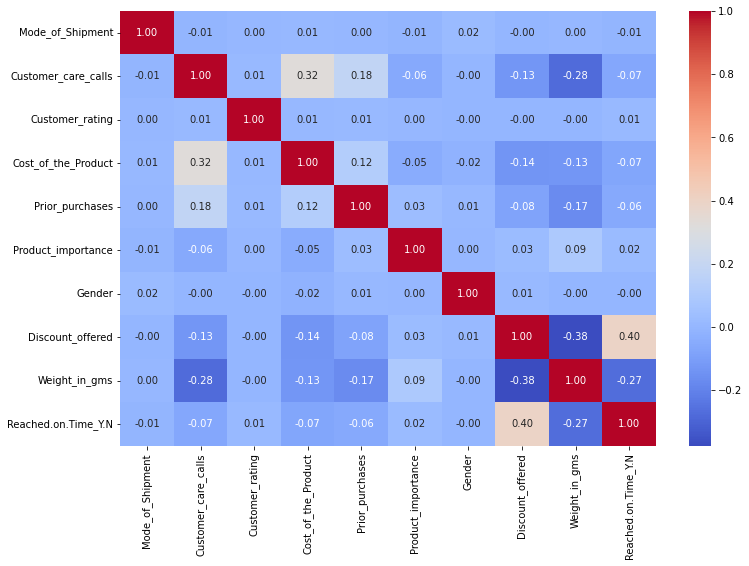

In [6]:
# check the variables are independent
ecommerce, encode_dict = get_ecommerce(
    data_path=Path('../data'),
    onehot_cols=config['data']['onehot_cols'],
    target_feature='Customer_rating'
)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(ecommerce.iloc[:, 1:].corr(), cmap='coolwarm', annot=True, fmt=".2f", ax=ax)
plt.show()

In [7]:
# Initialize SHAP
explainer = shap.TreeExplainer(model)
shap_values = np.array(explainer.shap_values(X_test))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Model summary explanation 

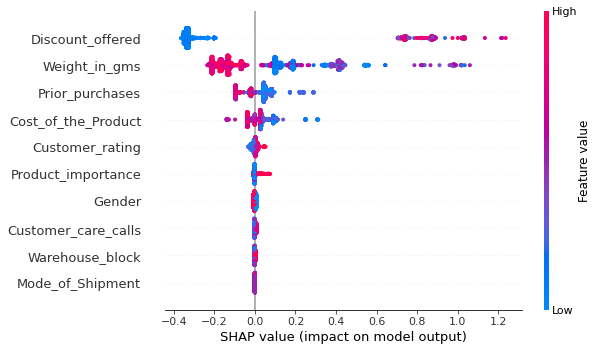

In [8]:
shap.summary_plot(shap_values, X_test)

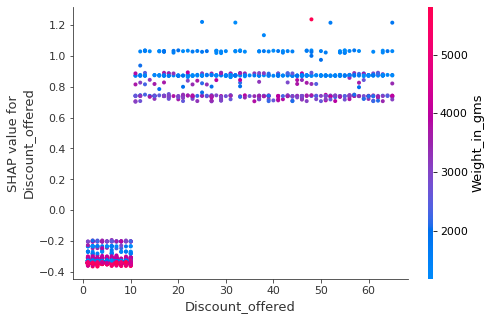

In [9]:
shap.dependence_plot('Discount_offered', shap_values, features=X_test, interaction_index='Weight_in_gms')

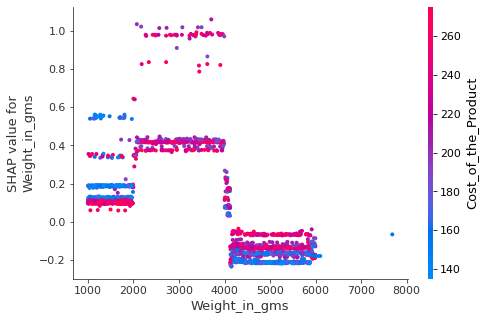

In [10]:
shap.dependence_plot('Weight_in_gms', shap_values, features=X_test, interaction_index='Cost_of_the_Product')

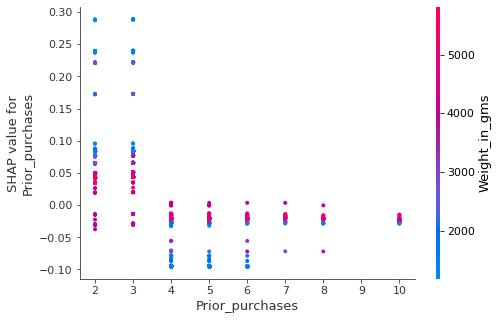

In [11]:
shap.dependence_plot('Prior_purchases', shap_values, features=X_test, interaction_index='Weight_in_gms')

Interesting findings: 

- `Discount_offered`: From summary plot and dependence plot, we can know that discount does not often happen. Most of data are in 0-10 and these customers who had lower numbers of discount offered have negative influnce to the model prediction at **NOT** reached on time(which means their product was more likely reached on time). However, if the number of discount offered is over 10 times, these data have positive impact to the model prediction. 
- `Weight_in_gms`: From summary plot, Heavier product usually have negative impact to the classification(not reached on time). We can see from the dependence plot, that customers who records the low costs with under 2000 grams give positive impact(not reached on time) and with over 4000 weights give negative impact(reached on time)
- `Prior_purchases`: From summary plot and dependence plot, customers who had higher purchase experiences usually have negative influnence to the prediction. However, the low number of prior purchases usually have positive impact to the classification, meaning that usually they don't reach on time. Also, low purchase experiences customers who has lower weights have more positive impact than who has higher weights customers. 
- `Cost_of_the_Product`: From summary plot, higher costs leads negetive influnence to the prediction.
- `Customer_care_calls`: Lower number of customer care calls contribute negative impact to the predictions. 

### Sample explanation 

In [12]:
np.random.seed(7)
idx_bool = y_test == y_pred
y_correct = y_test[idx_bool]
X_correct = X_test[idx_bool]

sample_index = []
for label in range(2):
    index = np.random.choice(y_correct[y_correct == label].index)
    sample_index.append(int(np.arange(len(y_test))[y_test.index == index]))

Choose a sample from correct predictions that has label=0(reached on time), `Discount_offered` and `Weight_in_gms` have a little big negative impact to the classification. `Discount_offered` has the most big influence by 0.333142.

In [13]:
i = sample_index[0]
sample_info = pd.Series(shap_values[i], index=X_test.columns)
sample_info.name = X_test.index[i]
print(sample_info)

shap.force_plot(explainer.expected_value, shap_values[i], features=X_test.iloc[i])

Warehouse_block        0.003416
Mode_of_Shipment       0.000000
Customer_care_calls   -0.003382
Customer_rating        0.012772
Cost_of_the_Product    0.030713
Prior_purchases        0.043705
Product_importance    -0.003216
Gender                -0.002215
Discount_offered      -0.339660
Weight_in_gms         -0.212512
Name: 4999, dtype: float32


Choose a sample from correct predictions that has label=1(not reached on time), `Prior_purchases`,  `Weight_in_gms` and `Discount_offered` have positive impact to the classification. `Discount_offered` has the most big influence by 0.733389.

In [14]:
i = sample_index[1]
sample_info = pd.Series(shap_values[i], index=X_test.columns)
sample_info.name = X_test.index[i]
print(sample_info)

shap.force_plot(explainer.expected_value, shap_values[i], features=X_test.iloc[i])

Warehouse_block       -0.000244
Mode_of_Shipment       0.000000
Customer_care_calls    0.001448
Customer_rating       -0.003504
Cost_of_the_Product   -0.001192
Prior_purchases       -0.025669
Product_importance    -0.000996
Gender                 0.001612
Discount_offered       0.887602
Weight_in_gms          0.375256
Name: 2462, dtype: float32


## Explaination with LIME

In [15]:
categorical_features = ['Warehouse_block','Mode_of_Shipment', 'Product_importance', 'Gender', 'Customer_rating']
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, training_labels=y_train.values,
    mode='classification',
    feature_names=X_train.columns.values, 
    categorical_features=categorical_features,
    class_names=[0, 1]
)

### Sample explanation 

we'll use the same samples to compare with SHAP

This sample is not quite sure for the prediction, `Weight_in_gms`(4138.00 < Weight_in_gms <= 5031.00) and `Discount_offered`(7.00 < Discount_offered <= 10.00) contribute to the prediction(reached on time) and `Prior_purchases`(Prior_purchases <= 3.00) contribute to the prediction(not reached on time).

In [16]:
i = sample_index[0]
print('Sample index: ', X_test.index[i])
exp = explainer.explain_instance(
    data_row=X_test.iloc[i], 
    predict_fn=model.predict_proba, 
    num_features=5, 
)
exp.show_in_notebook(show_table=True)

Sample index:  4999


In [17]:
exp.as_list()

[('4138.00 < Weight_in_gms <= 5031.00', -0.11628670129094884),
 ('7.00 < Discount_offered <= 10.00', -0.07350504809116427),
 ('Prior_purchases <= 3.00', 0.03404136085607267),
 ('Cost_of_the_Product <= 170.00', 0.020120241169606208),
 ('0.00 < Product_importance <= 1.00', -0.005332002683784065)]

This sample is quite to the prediction, `Discount_offered`(Discount_offered > 10.00),  `Weight_in_gms`(1836.00 < Weight_in_gms <= 4138.00) and `Prior_purchases`(3.00 < Prior_purchases <= 4.00) contribute to the prediction(not reached on time)

In [18]:
i = sample_index[1]
print('Sample index: ', X_test.index[i])
exp = explainer.explain_instance(
    data_row=X_test.iloc[i], 
    predict_fn=model.predict_proba, 
    num_features=5, 
)
exp.show_in_notebook(show_table=True)

Sample index:  2462


In [19]:
exp.as_list()

[('Discount_offered > 10.00', 0.24779849681641963),
 ('1836.00 < Weight_in_gms <= 4138.00', 0.16589082959258064),
 ('3.00 < Prior_purchases <= 4.00', -0.0316892343017789),
 ('214.00 < Cost_of_the_Product <= 251.00', -0.0131813160733768),
 ('Mode_of_Shipment <= 1.00', 0.006196299570722208)]

# Explaining Predictions of  Regression Models

## Beijing Housing Dataset


Housing price of Beijing from 2011 to 2017, fetching from Lianjia.com

Content
It includes URL, ID, Lng, Lat, CommunityID, TradeTime, DOM(days on market), Followers, Total price, Price, Square, Living Room, number of Drawing room, Kitchen and Bathroom, Building Type, Construction time. renovation condition, building structure, Ladder ratio( which is the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average), elevator, Property rights for five years（It's related to China restricted purchase of houses policy), Subway, District, Community average price.

- url: the url which fetches the data
- id: the id of transaction
- Lng: and Lat coordinates, using the BD09 protocol.
- Cid: community id
- tradeTime: the time of transaction
- DOM: active days on market.Know more in https://en.wikipedia.org/wiki/Days_on_market
- followers: the number of people follow the transaction.
- totalPrice: the total price
- price: the average price by square
- square: the square of house
- livingRoom: the number of living room
- drawingRoom: the number of drawing room
- kitchen: the number of kitchen
- bathroom the number of bathroom
- floor: the height of the house. I will turn the Chinese characters to English in the next version.
- buildingType: including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).
- constructionTime: the time of construction
- renovationCondition: including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )
- buildingStructure: including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).
- ladderRatio: the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on - average.
- elevator: have ( 1 ) or not have elevator( 0 )
- fiveYearsProperty: if the owner have the property for less than 5 years,

Target column: **totalPrice** (plz remove **price** column from the predictors)

Most data is traded in 2011-2017, some of them is traded in Jan,2018, and some is even earlier(2010,2009)

All the data was fetching from https://bj.lianjia.com/chengjiao.

Acknowledgements
All the data was fetching from Lianjia

Inspiration
It may help you predict the housing price of Beijing.

In [20]:
housing = pd.read_csv("../data/housing/beijing_housing_2.csv")
housing.tail(5)

Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.


url            id  \
318846  https://bj.lianjia.com/chengjiao/BJYZ92311192....  BJYZ92311192   
318847  https://bj.lianjia.com/chengjiao/BJYZ92320171....  BJYZ92320171   
318848  https://bj.lianjia.com/chengjiao/BJYZ92324217....  BJYZ92324217   
318849  https://bj.lianjia.com/chengjiao/BJYZ92333313....  BJYZ92333313   
318850  https://bj.lianjia.com/chengjiao/BJYZ92363553....  BJYZ92363553   

               Lng        Lat            Cid   tradeTime  DOM  followers  \
318846  116.546899  39.755236  1111027377053  2016-06-10  1.0          8   
318847  116.497474  39.810115  1111027377957  2016-06-10  NaN          1   
318848  116.497256  39.804081  1111027380056  2016-06-05  1.0          2   
318849  116.501794  39.799347  1111027377054  2016-06-12  NaN          4   
318850  116.497474  39.810115  1111027377957  2016-06-11  1.0          0   

        totalPrice  price  square livingRoom drawingRoom  kitchen bathRoom  \
318846       350.0  20580  170.07          3           2        1        2   
318847       108.8  31006   35.09          1           0        1        1   
318848       359.0  35138  102.17          2           2        1        2   
318849       720.0  40373  178.34          4           2        1        2   
318850       450.0  48675   92.45          2           1        1        1   

       floor  buildingType constructionTime  renovationCondition  \
318846   中 5           4.0             2003                    1   
318847  中 24           1.0             2009                    1   
318848   中 7           4.0             2000                    3   
318849   中 5           4.0             2003                    4   
318850  中 17           4.0               未知                    4   

        buildingStructure  ladderRatio  elevator  fiveYearsProperty  subway  \
318846                  6        0.333       0.0                1.0     0.0   
318847                  6        0.222       1.0                0.0     1.0   
318848                  6        0.500       1.0                1.0     0.0   
318849                  2        0.500       0.0                1.0     0.0   
318850                  6        1.000       1.0                0.0     1.0   

        district  communityAverage  
318846         3           36545.0  
318847         3           54282.0  
318848         3           46927.0  
318849         3           54842.0  
318850         3           54282.0

## Model Building

In [21]:
from datetime import datetime

def load_housing_data(data_path):
    housing = pd.read_csv(data_path / 'housing' / "beijing_housing_2.csv")
    housing.drop("url", inplace=True, axis=1)
    housing['constructionTime'] = housing['constructionTime'].replace("未知", 'nan')
    housing.drop(housing[(housing['constructionTime'] == '1') | (housing['constructionTime'] == '0') | (housing['constructionTime'] == 'nan')].index, inplace=True)
    housing['constructionTime'] = housing['constructionTime'].astype('int')
    housing['floor_num'] = housing['floor'].apply(lambda x : x.split(" ")[-1])
    housing['floor_type'] = housing['floor'].apply(lambda x : x.split(" ")[0])
    housing['floor_num'] = housing['floor_num'].astype('int')
    housing.drop('floor', inplace=True, axis=1)
    housing.drop(housing[housing['floor_type'] == '未知'].index, inplace=True)
    housing['floor_type'] = housing['floor_type'].replace(to_replace=['顶','高','中','低','底'], value=[5,4,3,2,1])
    housing['floor_type'] = housing['floor_type'].astype('int')
    housing['tradeTime'] = housing['tradeTime'].apply(lambda x: int(datetime.timestamp(datetime.strptime(x, "%Y-%m-%d"))))
    housing['tradeTime'] = housing['tradeTime'].astype('int')
    housing['livingRoom'] = housing['livingRoom'].astype('int')
    housing['drawingRoom'] = housing['drawingRoom'].astype('int')
    housing['bathRoom'] = housing['bathRoom'].astype('int')
    housing['elevator'] = housing['elevator'].astype('int')
    housing['subway'] = housing['subway'].astype('int')
    
    # DOM hightly correlates with totalPrice, while buildingType weakly correlates with totalPrice. 
    dom_mean = housing['DOM'].mean()
    housing['DOM'].fillna(value=dom_mean, inplace=True)
    housing.dropna(inplace=True)
    housing['buildingType'] = housing['buildingType'].astype('int')
    dataset = housing.sample(frac=1)
    y = dataset.iloc[:,7]
    X = dataset.copy()
    X.drop(["id", "Cid", "price", "ladderRatio", "fiveYearsProperty", "totalPrice"], inplace=True, axis=1)
    # X['DOM'].fillna(value=dom_mean, inplace=True)
    return X, y

In [22]:
checkpoints = Path() / 'checkpoints'
if not checkpoints.exists():
    checkpoints.mkdir()

config = {
    'params': {
        'n_estimators': 1000,
        'max_depth' : 6,
        'learning_rate': 0.01, 
        'min_child_weight': 2,
        'objective' : 'reg:squarederror',
        'eval_metric' : ['rmse', 'mae'],
        'tree_method': 'hist',
        'random_state': 7,
        'n_jobs': 10,
        'reg_lambda': 1e-4
    },
    'name': 'reg.xgb',
}

params = config['params']

data_X, data_y = load_housing_data(data_path=Path('../data'))
X_train, y_train, X_test, y_test = separate_dataset(data_X, data_y)

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)
model.save_model(checkpoints / config['name'])

y_pred = model.predict(X_test)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
print(f'Root Mean Squared Error: {mse**(1/2):.4f}, Mean Absolute Error: {mae:.4f}')

Columns (1,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.


Root Mean Squared Error: 48.3981, Mean Absolute Error: 27.5183


## Explaination with SHAP

### Model summary explanation 

In [23]:
# Initialize SHAP
explainer = shap.TreeExplainer(model)
shap_values = np.array(explainer.shap_values(X_test))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


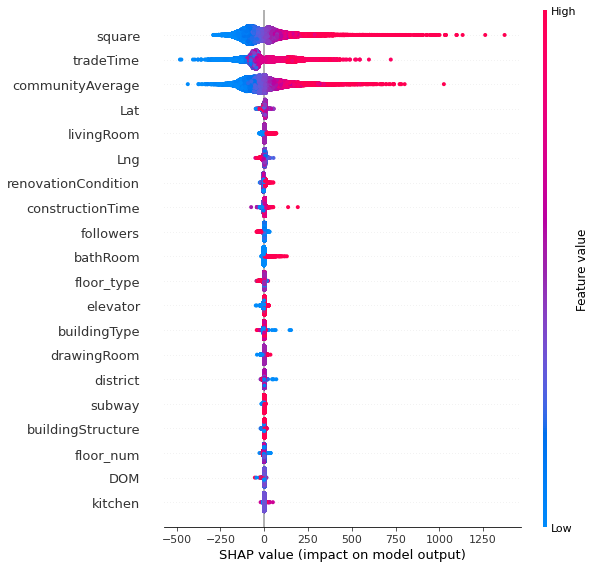

In [24]:
shap.summary_plot(shap_values, X_test)

Among all the features `square`, `tradeTime` and `communityAverage` features have impact to the regression. And higher square of the house, earlier transaction time and higher the average housing price at some area(there is no precise description) will have positive contribution to the house price regression, vice versa. Higher `livingRoom` and `bathRoom` will have a little positive impact to the prediction.

### Sample explanation 

In [33]:
np.random.seed(7)
idx_bool = y_test == y_pred
y_correct = y_test[idx_bool]
X_correct = X_test[idx_bool]

sample_index = np.random.choice(np.arange(len(y_test)), 2)

Sample `165127`: `square`(-114.10), `communityAverage`(-40.10) and `tradeTime`(-38.92) have a negative impact to the regression. 

In [26]:
i = sample_index[0]
sample_info = pd.Series(shap_values[i], index=X_test.columns)
sample_info.name = X_test.index[i]
print(sample_info)

shap.force_plot(explainer.expected_value, shap_values[i], features=X_test.iloc[i])

Lng                      1.756263
Lat                     -0.715616
tradeTime              -38.917835
DOM                      0.489406
followers                2.612844
square                -114.108437
livingRoom             -10.032125
drawingRoom             -7.246936
kitchen                  0.221620
bathRoom                -1.650619
buildingType             0.203386
constructionTime        -2.733968
renovationCondition     -1.539834
buildingStructure        0.406572
elevator                 0.754498
subway                   0.536203
district                 1.352836
communityAverage       -40.106842
floor_num                0.396685
floor_type               0.874643
Name: 165127, dtype: float32


Sample `278172`: `square`(46.26) has a positive influence to the regression. `communityAverage`(-120.92) and `tradeTime`(-121.07) have a negative impact to the regression. 

In [27]:
i = sample_index[1]
sample_info = pd.Series(shap_values[i], index=X_test.columns)
sample_info.name = X_test.index[i]
print(sample_info)

shap.force_plot(explainer.expected_value, shap_values[i], features=X_test.iloc[i])

Lng                     -9.022638
Lat                     -5.993508
tradeTime             -121.074730
DOM                      1.013532
followers                0.492557
square                  46.261623
livingRoom               4.927948
drawingRoom             -0.020192
kitchen                  0.002012
bathRoom                -1.095325
buildingType             0.134886
constructionTime         1.655311
renovationCondition     -3.416449
buildingStructure       -0.844791
elevator                 0.931604
subway                  -1.651095
district                -6.601780
communityAverage      -120.921814
floor_num                0.177744
floor_type               1.153054
Name: 278172, dtype: float32


## Explaination with LIME

### Sample explanation 

In [29]:
categorical_features = ['buildingType', 'renovationCondition', 'buildingStructure', 'elevator', 'subway']
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, training_labels=y_train.values,
    mode='regression',
    feature_names=X_train.columns.values, 
    categorical_features=categorical_features,
)

Sample `165127`: `square`(square <= 57.90), `tradeTime`(2013-12-15 15:00:00 < tradeTime <= 2015-09-23 15:00:00), `communityAverage`(46505.00 < communityAverage <= 59025.00) have a negative contribution to the prediction. However `buildingStructure`(2.00 < buildingStructure <= 6.00) has a little positive impact to the regression. This result is similar with SHAP.

In [30]:
i = sample_index[0]
print('Sample index: ', X_test.index[i])
exp = explainer.explain_instance(
    data_row=X_test.iloc[i], 
    predict_fn=model.predict, 
    num_features=5, 
)
exp.show_in_notebook(show_table=True)

Sample index:  165127


In [31]:
exp.as_list()

[('square <= 57.90', -188.4292769857749),
 ('1387119600.00 < tradeTime <= 1443020400.00', -89.26850374964492),
 ('46505.00 < communityAverage <= 59025.00', -82.58462010760411),
 ('2.00 < buildingStructure <= 6.00', 14.783908238621352),
 ('livingRoom <= 1.00', -13.124804140231575)]

Sample `278172`: `square`(square > 98.27) has a positive influence to the regression. `communityAverage`(communityAverage <= 46505.00) and `tradeTime`(tradeTime <= 2013-12-15 15:00:00) have a negative impact to the regression. 

In [32]:
i = sample_index[1]
print('Sample index: ', X_test.index[i])
exp = explainer.explain_instance(
    data_row=X_test.iloc[i], 
    predict_fn=model.predict, 
    num_features=5, 
)
exp.show_in_notebook(show_table=True)

Sample index:  278172


In [33]:
exp.as_list()

[('square > 98.27', 272.37581397439664),
 ('communityAverage <= 46505.00', -177.4485401212377),
 ('tradeTime <= 1387119600.00', -153.6057237989877),
 ('Lng > 116.48', -18.29899634828163),
 ('subway <= 0.00', -13.922515026263085)]

# Compare results of LIME and SHAP

Both LIME and SHAP are insightful. LIME shows more on sample explanation due to show the rules(if the model is tree-based). But it is unstable, every time I run the explainer some time the result changes. SHAP takes some times to inference when the number of feature getting larger, but has strength on summary plot.